# Mathematical Engineering - Financial Engineering, FY 2024-2025
# Risk Management - Exercise 4: Credit Portfolio Single Factor Model

In [1]:
# Importing the libraries

%reset -f
import os
import pickle
import numpy as np
import pandas as pd
from pathlib import Path


from scipy.stats import norm

from boot import bootstrap
from ex1_utilities import (
    business_date_offset,
    getDiscount
)
from ex3_utilities import (
    hs_var_es,
    compute_VaR_for_rho
)

In [2]:

def extract_data(file_path):
    df_cleaned = pd.read_excel(file_path, sheet_name="Sheet1")

    # Extraction of dates

    settlement_date = df_cleaned.iloc[6, 4]
    depos_dates = df_cleaned.iloc[9:15, 3].tolist()
    futures_dates = df_cleaned.iloc[10:19, 16:18].values.tolist()
    swaps_dates = df_cleaned.iloc[37:54, 3].tolist()

    # Extraction of deposit rates
    depos_rates = df_cleaned.iloc[9:15, 7:9].values
    depos_rates = np.array(depos_rates, dtype=np.float64) / 100  # Conversion to float

    # Extraction of futures rates
    futures_rates = df_cleaned.iloc[26:35, 7:9].values
    futures_rates = np.array(futures_rates, dtype=np.float64) / 100  # Conversion to float

    # Extraction of swap rates
    swaps_rates = df_cleaned.iloc[37:54, 7:9].values
    swaps_rates = np.array(swaps_rates, dtype=np.float64) / 100  # Conversion to float

    return {
        "settlement_date": settlement_date,
        "depos_dates": depos_dates,
        "futures_dates": futures_dates,
        "swaps_dates": swaps_dates,
        "depos_rates": depos_rates,
        "futures_rates": futures_rates,
        "swaps_rates": swaps_rates
    }

# Extract from file excel
file_path = "MktData_CurveBootstrap.xls"
data = extract_data(file_path)


#  Create the `dates_set` dictionary containing the extracted dates
dates_set = {
    'settlement': data['settlement_date'],
    'depos': data['depos_dates'],
    'futures': data['futures_dates'],
    'swaps': data['swaps_dates']
}
# Create the `rates_set` dictionary containing the extracted rates
rates_set = {
    'depos': data['depos_rates'],
    'futures': data['futures_rates'],
    'swaps': data['swaps_rates']
}

# Calculate dates and discounts with bootstrap
dates, discounts = bootstrap(dates_set, rates_set)

today = pd.to_datetime('2023-02-02')

In [3]:
# Parameters
issuers_num = 100  # Number of bonds in the portfolio
maturity = 2  # Maturity in years

rating = "IG"  # Initial credit rating

# Compute bond expiry date
expiry = business_date_offset(today, year_offset=maturity)
# Generate payment dates
datepag=[business_date_offset(today, month_offset=6*i) for i in range(0,5)]

transition_matrix = pd.DataFrame(
    [[0.73, 0.25, 0.02], [0.35, 0.6, 0.05], [0, 0, 1]],
    index=["IG", "HY", "Def"],
    columns=["IG", "HY", "Def"],
)
transition_matrix2y=transition_matrix @ transition_matrix
print(transition_matrix)

recovery_rate = 0.4     # Recovery rate in the event of default
face_value = 1_000_000  # Face value of each bond
rho = 0.15

mc_simulations = 1_000_000  # Number of Monte Carlo simulation scenarios

       IG    HY   Def
IG   0.73  0.25  0.02
HY   0.35  0.60  0.05
Def  0.00  0.00  1.00


In [4]:
# Q1-Q3: Portfolio MtM Evaluate the present value in a years' time under various scenarios

# Compute discount factors for the payment dates of the bond
df_expiry = getDiscount(dates, discounts,datepag)

# Extract the discount factor at the bond's final maturity
discexp=df_expiry[-1]
print(df_expiry)

[1.         0.98559455 0.96830131 0.9526023  0.93889301]


In [5]:
# We consider the default at the midpoint
# Compute the forward discount factor from 1Y to 2Y
frwdisc1y2y=df_expiry[4]/df_expiry[2]
# Compute the 0-0.5-year forward discount factor
frwdis6mesi=df_expiry[1]
# Compute the 1-year discount factor considering default probability and recovery
df_1y_def =(1-transition_matrix.loc["IG", "Def"])*df_expiry[2]+transition_matrix.loc["IG", "Def"]*df_expiry[1]*recovery_rate

# Compute DF(1y→2y | IG)
df_1y2ydef=(1-transition_matrix.loc["IG", "Def"])*frwdisc1y2y+transition_matrix.loc["IG", "Def"]*df_expiry[3]/df_expiry[2]*recovery_rate

# Compute DF(1y→2y | HY)
df_1y2yHY=(1-transition_matrix.loc["HY", "Def"])*frwdisc1y2y+transition_matrix.loc["HY", "Def"]*df_expiry[3]/df_expiry[2]*recovery_rate

# Compute the expected discount factor at 2y, taking into account all rating transitions from IG
df_2y_def = (
        transition_matrix.loc["IG", "IG"]*df_expiry[2]*df_1y2ydef +
        transition_matrix.loc["IG", "HY"]*df_expiry[2]*df_1y2yHY +
        transition_matrix.loc["IG", "Def"]*df_expiry[1]*recovery_rate
)

# -- Forward default probabilities between year 1 and year 2 --
# Compute survival probabilities for IG
survival_prob_1y =1-transition_matrix.loc["IG", "Def"]
survival_prob_2y =1-transition_matrix2y.loc["IG", "Def"]
# Compute P(def 1-2 | alive in 0-1) for IG
forwprob=(survival_prob_1y-survival_prob_2y)/survival_prob_1y
# Compute survival probabilities for HY
survival_prob_1yhy =1-transition_matrix.loc["HY", "Def"]
survival_prob_2yhy =1-transition_matrix2y.loc["HY", "Def"]
# Compute P(def 1-2 | alive in 0-1) for HY
forwprobhy=(survival_prob_1yhy-survival_prob_2yhy)/survival_prob_1yhy

# --- Forward bond prices and portfolio mark-to-market ---
# Forward price of a 1y bond (from today t=0), assuming issuer is IG at t=1
fwd_price_ig =df_1y2ydef*face_value
# Forward price of a 1y bond, assuming the issuer is HY at t=1
fwd_price_hy =df_1y2yHY*face_value
# Current mark-to-market of a single 2y bond, accounting for credit risk and transitions
bond_mtm=df_2y_def*face_value
# Mark-to-market of the entire portfolio (100 issuers)
ptf_mtm =bond_mtm*issuers_num

print(f"Forward price Investment Grade €{fwd_price_ig:,.2f}")
print(f"Forward price High Yield €{fwd_price_hy:,.2f}")

print(f"Portfolio MtM: €{ptf_mtm:,.2f}")


Forward price Investment Grade €958,106.69
Forward price High Yield €940,823.27
Portfolio MtM: €91,288,211.35


In [6]:
# Q4: Monte Carlo simulation
# Barriers and PnL for a single IG issuer

seed=0      # Set random seed

# Compute VaR considering only default risk
VaRonlydef, _, _, loss  = compute_VaR_for_rho(
    rho=rho,
    transition_matrix=transition_matrix,
    df_expiry=df_expiry[2],
    recovery_rate=recovery_rate,
    frwdis6mesi=frwdis6mesi,
    df_1y2ydef=df_1y2ydef,
    df_1y2yHY=df_1y2yHY,
    bond_mtm=bond_mtm,
    face_value=face_value,
    issuers_num=issuers_num,
    mc_simulations=mc_simulations,
    only_default=True,
    seed=seed
)
# Compute VaR including both default and downgrade (migration) risk
VaRex4d, avgdefault,avgdowngrade, _  = compute_VaR_for_rho(
    rho=rho,
    transition_matrix=transition_matrix,
    df_expiry=df_expiry[2],
    recovery_rate=recovery_rate,
    frwdis6mesi=frwdis6mesi,
    df_1y2ydef=df_1y2ydef,
    df_1y2yHY=df_1y2yHY,
    bond_mtm=bond_mtm,
    face_value=face_value,
    issuers_num=issuers_num,
    mc_simulations=mc_simulations,
    only_default=False,
    seed=seed
)

print(f"Average default: {avgdefault}")
print(f"Average downgrade: {avgdowngrade}")

print(f"VaR only defaults: €{VaRonlydef:,.2f}")

print(f"VaR with defaults and downgrades: €{VaRex4d:,.2f}")



Average default: 2.001184
Average downgrade: 24.989382
VaR only defaults: €5,232,414.98
VaR with defaults and downgrades: €6,062,019.36


In [7]:
# Q5: Monte Carlo Simulation with 0% correlation

VaRex5  = compute_VaR_for_rho(
    rho=0,
    transition_matrix=transition_matrix,
    df_expiry=df_expiry[2],
    recovery_rate=recovery_rate,
    frwdis6mesi=frwdis6mesi,
    df_1y2ydef=df_1y2ydef,
    df_1y2yHY=df_1y2yHY,
    bond_mtm=bond_mtm,
    face_value=face_value,
    issuers_num=issuers_num,
    mc_simulations=mc_simulations,
    only_default=False,
    seed=seed
)[0]

print(f"VaR with defaults and downgrades: with 0 correlation : €{VaRex5:,.2f}")


VaR with defaults and downgrades: with 0 correlation : €2,264,003.92


In [8]:
# Monte Carlo Simulation with 30% correlation

VaRex5b = compute_VaR_for_rho(
    rho=0.3,
    transition_matrix=transition_matrix,
    df_expiry=df_expiry[2],
    recovery_rate=recovery_rate,
    frwdis6mesi=frwdis6mesi,
    df_1y2ydef=df_1y2ydef,
    df_1y2yHY=df_1y2yHY,
    bond_mtm=bond_mtm,
    face_value=face_value,
    issuers_num=issuers_num,
    mc_simulations=mc_simulations,
    only_default=False,
    seed=seed
)[0]

print(f"VaR  with defaults and downgrades: with 0.3 correlation : €{VaRex5b:,.2f}")

VaR  with defaults and downgrades: with 0.3 correlation : €10,060,951.75


Text(0.5, 1.0, 'Loss distribution')

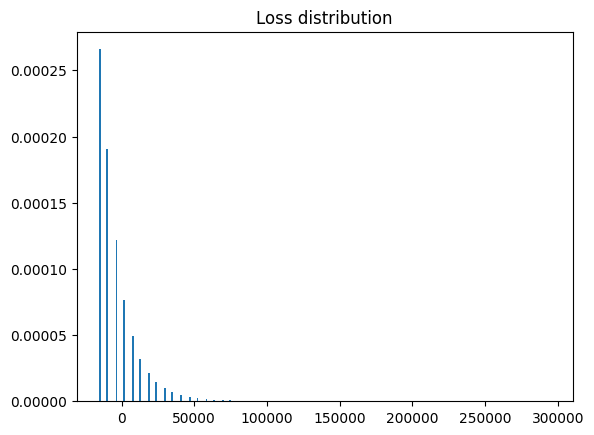

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(loss, bins=250, density=True)
plt.title("Loss distribution")

In [10]:
# Q7: Adjusting the Model for Lower Recovery Rate in Case of Downgrade

# Set recovery rates: 40% for default, 10% for downgrade
recovery_rate1=0.4
recovery_rate2=0.1
# Compute forward discount factor from 1Y to 2Y
frwdisc1y2y = df_expiry[4] / df_expiry[2]
# Compute the 0-0.5-year forward discount factor
frwdis6mesi = df_expiry[1]
# Compute the 1-year discount factor considering default probability and recovery
df_1y_def = (1 - transition_matrix.loc["IG", "Def"]) * df_expiry[2] + transition_matrix.loc["IG", "Def"] * df_expiry[1] * recovery_rate1
# Compute DF(1y→2y | IG)
df_1y2ydef = (1 - transition_matrix.loc["IG", "Def"]) * frwdisc1y2y + transition_matrix.loc["IG", "Def"] * (df_expiry[3] / df_expiry[2]) * recovery_rate1
# Forward discount factor 1Y→2Y assuming issuer is downgraded to HY (with lower recovery)
df_1y2yHY  = (1 - transition_matrix.loc["HY", "Def"]) * frwdisc1y2y + transition_matrix.loc["HY", "Def"] * (df_expiry[3] / df_expiry[2]) * recovery_rate2
# Compute expected 2Y discount factor from IG issuers, accounting for all transitions
df_2y_def  = (
        transition_matrix.loc["IG", "IG"] * df_expiry[2] * df_1y2ydef +
        transition_matrix.loc["IG", "HY"] * df_expiry[2] * df_1y2yHY +
        transition_matrix.loc["IG", "Def"] * df_expiry[1] * recovery_rate1
)
# Compute the current mark-to-market of a single bond
bond_mtm    = df_2y_def * face_value
# Compute MtM of the entire portfolio (100 bonds)
ptf_mtm =bond_mtm*issuers_num

# --- Bisection Method to Find rho such that VaR Matches the Baseline Scenario ---
target_VaR = VaRex4d  # Target VaR
tol_VaR = 1e3            # Tolerance on VaR (1000 EUR)
tol_rho = 1e-4           # Tolerance on rho
max_iter = 50

# Bisection bounds
rho_low = 0.0
rho_high = 1.0

# Track the best candidate values
best_rho = None
best_diff = float('inf')
best_VaR = None

for i in range(max_iter):
    rho_mid = (rho_low + rho_high) / 2
    # Compute VaR using modified recovery and current rho
    VaR_mid = compute_VaR_for_rho(rho_mid, transition_matrix,
            df_expiry[2], recovery_rate1, frwdis6mesi,
            df_1y2ydef, df_1y2yHY, bond_mtm, face_value,
            issuers_num, mc_simulations, seed)[0]

    diff = VaR_mid - target_VaR

    # Update best candidate if closer to target
    if abs(diff) < abs(best_diff):
        best_diff = diff
        best_rho = rho_mid
        best_VaR = VaR_mid

    print(f"Iteration {i+1}: rho = {rho_mid:.5f}, VaR = {VaR_mid:,.2f}, diff = {diff:,.2f}")

    # Check stopping condition
    if abs(diff) < tol_VaR or (rho_high - rho_low) < tol_rho:
        break

    # Adjust bisection interval based on sign of difference
    if diff > 0:
        # VaR too high → decrease rho
        rho_high = rho_mid
    else:
        # VaR too low → increase rho
        rho_low = rho_mid

print("\n--- Risultato finale ---")
print(f"rho trovato: {best_rho:.5f} con VaR = {best_VaR:,.2f} (diff = {best_diff:,.2f})")

Iteration 1: rho = 0.50000, VaR = 16,467,800.22, diff = 10,405,780.86
Iteration 2: rho = 0.25000, VaR = 9,073,424.39, diff = 3,011,405.03
Iteration 3: rho = 0.12500, VaR = 5,709,396.10, diff = -352,623.26
Iteration 4: rho = 0.18750, VaR = 7,401,002.72, diff = 1,338,983.36
Iteration 5: rho = 0.15625, VaR = 6,561,627.05, diff = 499,607.69
Iteration 6: rho = 0.14062, VaR = 6,125,919.09, diff = 63,899.74
Iteration 7: rho = 0.13281, VaR = 5,920,822.44, diff = -141,196.92
Iteration 8: rho = 0.13672, VaR = 6,029,798.40, diff = -32,220.96
Iteration 9: rho = 0.13867, VaR = 6,061,838.63, diff = -180.73

--- Risultato finale ---
rho trovato: 0.13867 con VaR = 6,061,838.63 (diff = -180.73)


In [11]:
# Check that the found rho reproduces the target VaR

rho_check=0.13867
recovery_rate1=0.4
recovery_rate2=0.1
# Forward discount factor from 1Y to 2Y
frwdisc1y2y = df_expiry[4] / df_expiry[2]
# Compute the 0-0.5-year forward discount factor
frwdis6mesi = df_expiry[1]
# Discount factor for 1Y bond accounting for default (recovery = 40%)
df_1y_def = (1 - transition_matrix.loc["IG", "Def"]) * df_expiry[2] + transition_matrix.loc["IG", "Def"] * df_expiry[1] * recovery_rate1
# Forward discount factor 1Y→2Y assuming IG at t=1
df_1y2ydef = (1 - transition_matrix.loc["IG", "Def"]) * frwdisc1y2y + transition_matrix.loc["IG", "Def"] * (df_expiry[3] / df_expiry[2]) * recovery_rate1
# Forward discount factor 1Y→2Y assuming HY at t=1 with downgraded recovery
df_1y2yHY  = (1 - transition_matrix.loc["HY", "Def"]) * frwdisc1y2y + transition_matrix.loc["HY", "Def"] * (df_expiry[3] / df_expiry[2]) * recovery_rate2
# Compute expected 2Y discount factor from IG path with updated recovery assumptions
df_2y_def  = (
        transition_matrix.loc["IG", "IG"] * df_expiry[2] * df_1y2ydef +
        transition_matrix.loc["IG", "HY"] * df_expiry[2] * df_1y2yHY +
        transition_matrix.loc["IG", "Def"] * df_expiry[1] * recovery_rate1
)

bond_mtm    = df_2y_def * face_value
ptf_mtm =bond_mtm*issuers_num

# return VaR_ex, avgdefault, avgdowngrade, lossexd
VaRex4d_check, avgdefault, avgdowngrade, lossexd  = compute_VaR_for_rho(
    rho=rho_check,
    transition_matrix=transition_matrix,
    df_expiry=df_expiry[2],
    recovery_rate=recovery_rate1,
    frwdis6mesi=frwdis6mesi,
    df_1y2ydef=df_1y2ydef,
    df_1y2yHY=df_1y2yHY,
    bond_mtm=bond_mtm,
    face_value=face_value,
    issuers_num=issuers_num,
    mc_simulations=mc_simulations,
    only_default=False,
    seed=seed
)

print(f"Average default: {avgdefault}")
print(f"Average downgrade: {avgdowngrade}")

print(f"VaR with defaults and downgrades: €{VaRex4d_check:,.2f}")

Average default: 2.001207
Average downgrade: 24.989608
VaR with defaults and downgrades: €6,061,838.63


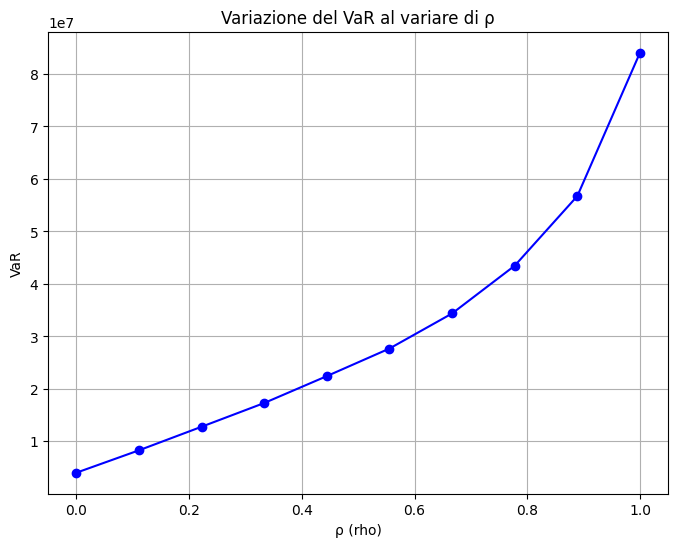

In [12]:
# Create a vector of rho values from 0 to 1
rho_values = np.linspace(0, 1, 10)
# Compute the corresponding VaR for each rho
VaR_values= [compute_VaR_for_rho(rho2, transition_matrix,
            df_expiry[2], recovery_rate2, frwdis6mesi,
            df_1y2ydef, df_1y2yHY, bond_mtm, face_value,
            issuers_num, mc_simulations,False, seed)[0] for rho2 in rho_values]

# Plot the results
plt.figure(figsize=(8,6))
plt.plot(rho_values, VaR_values, marker='o', linestyle='-', color='blue')
plt.xlabel('ρ (rho)')
plt.ylabel('VaR')
plt.title('Variazione del VaR al variare di ρ')
plt.grid(True)
plt.show()

In [ ]:
% Final Project Group 4.A
%
% AY2024-2025
%
% Federico Favali
% Amirreza Khajouei
%

% Clear workspace and close all figures
clear
close all
clc
warning('off', 'all')
format long

%%

% Joint migration matrix from CreditMetrics Table 8.2
% Rows: Final rating of BBB-rated firm
% Columns: Final rating of A-rated firm
% Ratings: AAA, AA, A, BBB, BB, B, CCC, Default

% load joint credit movements matrix
load joint_counts.mat

% total number of cases
N=sum(sum(joint_counts));

% Historically tabulated joint credit quality co-movement
empirical_joint_prob=joint_counts/N;

% probability of a firm with initial rating A to go in x in 3 months
marginal_A = sum(empirical_joint_prob, 1);    % sum over rows
% probability of a firm with initial rating BBB to go in x in 3 months
marginal_BBB = sum(empirical_joint_prob, 2);  % sum over columns


% Cumulative distributions
cdf_A = cumsum(marginal_A);        % 1×8
cdf_BBB = cumsum(marginal_BBB);    % 8×1
z_A = [-Inf, norminv(cdf_A)];       % 1×9: thresholds for A
z_BBB = [-Inf; norminv(cdf_BBB)];   % 9×1: thresholds for BBB


% bivariate_normal_cdf = @(x, y, rho) mvncdf([x, y], [0, 0], [1, rho; rho, 1]);

% modes = {'MSE', 'MAE', 'likelihood','KL','JSD'};
% P_results = cell(length(modes),1);
%
% % modes = {'MSE', 'MAE', 'likelihood', 'weighted_MAE'};
% % modes = {'weighted_MAE'};
% for i = 1:length(modes)
%     mode = modes{i};
%     [calibrated_rho, loss_value] = calibrate_rho(empirical_joint_prob, z_BBB, z_A, mode);
%     % plot_objective_function(empirical_joint_prob, z_BBB, z_A, mode);
% end
%%
modes = {'MSE', 'MAE', 'likelihood','KL','JSD','weighted MAE','weighted MSE'};
P_results = cell(length(modes), 1);

for i = 1:length(modes)
    mode = modes{i};

    [calibrated_rho, loss_value] = calibrate_rho(empirical_joint_prob, z_BBB, z_A, mode);

    % Save the results in a struct
    P_results{i} = struct( ...
        'mode', mode, ...
        'rho', calibrated_rho, ...
        'loss', loss_value ...
    );

    % Print the result
    fprintf('Mode: %-12s | Calibrated ρ(3m) = %.6f | Loss = %.8e\n', mode, calibrated_rho, loss_value);

    plot_objective_function(empirical_joint_prob, z_BBB, z_A, mode);
end

% Put rhos values in a vector
rhos = cellfun(@(s) s.rho, P_results);




In [ ]:
function [calibrated_rho, loss_value] = calibrate_rho(observed_joint_probs, z_BBB, z_A, mode)
    rho_min = 0;
    % rho_max = 1;
    rho_max=0.15;
    objective = @(rho) loss_function(rho, observed_joint_probs, z_BBB, z_A, mode);

    num_grid_points = 200;
    grid_rhos = linspace(rho_min + 0.01, rho_max - 0.01, num_grid_points);
    grid_losses = zeros(size(grid_rhos));

    for i = 1:num_grid_points
        grid_losses(i) = objective(grid_rhos(i));
    end
    [min_grid_loss, min_idx] = min(grid_losses);
    best_grid_rho = grid_rhos(min_idx);

    % Use the grid minimum as starting point for fmincon
    rho0 = best_grid_rho;

    % fmincon options
    opts = optimoptions('fmincon', 'Display','none', 'TolX', 1e-8, 'TolFun', 1e-10);

    % Run fmincon using the best grid point as initial guess
    [calibrated_rho, loss_value] = fmincon( ...
        objective, rho0, ...     % Objective function and initial rho
        [], [], [], [], ...      % No linear constraints
        rho_min, rho_max, ...    % Lower and upper bounds on rho
        [], opts);               % No nonlinear constraints, custom options

    %%


    % Check if fmincon actually improved the result
    if loss_value > min_grid_loss
        warning('fmincon did not improve on the grid search result. Using grid result instead.');
        calibrated_rho = best_grid_rho;
        loss_value = min_grid_loss;
    end


end

In [ ]:
function loss = loss_function(rho, observed_joint_probs, z_BBB, z_A, mode)
    theoretical_probs = calculate_theoretical_joint_probs(z_BBB, z_A, rho);

    switch mode
        case 'MSE'
            loss = sum(sum((theoretical_probs - observed_joint_probs).^2));

        case 'MAE'
            loss = sum(sum(abs(theoretical_probs - observed_joint_probs)));

        case 'likelihood'
            epsilon = 1e-10;
            mask = observed_joint_probs > 0;
            log_likelihood = sum(observed_joint_probs(mask) .* log(theoretical_probs(mask) + epsilon));
            loss = -log_likelihood;

        case 'KL'
            epsilon = 1e-10;
            % Avoid division by zero and log(0)
            P = observed_joint_probs(:);
            Q = max(theoretical_probs(:), epsilon);

            mask = P > 0;  % Only compute where observed > 0
            loss = sum(P(mask) .* log(P(mask) ./ Q(mask)));
        case 'JSD'
            % Jensen–Shannon divergence
            epsilon = 1e-10;
            P = observed_joint_probs(:);
            Q = theoretical_probs(:);
            % ensure no zeros
            Q = max(Q, epsilon);
            M = 0.5 * (P + Q);
            mask = M > 0;  % only where M>0
            % D_JS = ½ KL(P||M) + ½ KL(Q||M)
            D1 = sum(P(mask) .* log((P(mask) + epsilon) ./ (M(mask) + epsilon)));
            D2 = sum(Q(mask) .* log((Q(mask) + epsilon) ./ (M(mask) + epsilon)));
            loss = 0.5 * (D1 + D2);

        case 'weighted MSE'
            [i_idx, j_idx] = ndgrid(1:8, 1:8);
            weights = i_idx + j_idx;
            % Calculate weighted MSE
            squared_errors = (theoretical_probs - observed_joint_probs).^2;
            weighted_errors = weights .* squared_errors;
            loss = sum(sum(weighted_errors));

        case 'weighted MAE'
            [i_idx, j_idx] = ndgrid(1:8, 1:8);
            weights = i_idx + j_idx;
            errors = abs(theoretical_probs - observed_joint_probs);
            weighted_errors = weights .* errors;
            loss = sum(sum(weighted_errors));
        otherwise
            error('Unsupported loss function');
    end
end

In [ ]:
function joint_probs = calculate_theoretical_joint_probs(z_BBB, z_A, rho)
    % Create matrices for all combinations of indices
    [I, J] = ndgrid(1:8, 1:8);

    % Get the z values for all combinations
    z_BBB_i = z_BBB(I);
    z_BBB_i_plus_1 = z_BBB(I+1);
    z_A_j = z_A(J);
    z_A_j_plus_1 = z_A(J+1);

    % Create correlation matrix for mvncdf
    corr_matrix = [1 rho; rho 1];
    mu = [0, 0];

    % For MATLAB's mvncdf

    P11 = reshape(mvncdf([z_BBB_i_plus_1(:), z_A_j_plus_1(:)], mu, corr_matrix), size(I));
    P10 = reshape(mvncdf([z_BBB_i_plus_1(:), z_A_j(:)], mu, corr_matrix), size(I));
    P01 = reshape(mvncdf([z_BBB_i(:), z_A_j_plus_1(:)], mu, corr_matrix), size(I));
    P00 = reshape(mvncdf([z_BBB_i(:), z_A_j(:)], mu, corr_matrix), size(I));

    % Calculate the final probabilities matrix
    joint_probs = P11 - P10 - P01 + P00;
end